In [1]:
# # for logging 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers import TestTubeLogger
from pytorch_lightning.loggers import WandbLogger
import wandb

# For metrics
from pytorch_lightning import metrics

import math
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import io
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer






from pytorch_lightning.callbacks.early_stopping import EarlyStopping # The EarlyStopping callback can be used to monitor a validation metric and stop the training when no improvement is observed.
"""
    To enable it:

    Import EarlyStopping callback.

    Log the metric you want to monitor using log() method.

    Init the callback, and set monitor to the logged metric of your choice.

    Pass the EarlyStopping callback to the Trainer callbacks flag.
"""

from pytorch_lightning import seed_everything
# seed_everything(42)

In [2]:
from pytorch_lightning.metrics import Metric
from pytorch_lightning.metrics.utils import _input_format_classification
from sklearn.metrics import classification_report
class MyClassificationReport(Metric):
    def __init__(self,threshold: float = 0.5,compute_on_step: bool = True,dist_sync_on_step: bool = False):
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
        )

        self.threshold = threshold
        self.add_state("preds", default=[], dist_reduce_fx=None)
        self.add_state("target", default=[], dist_reduce_fx=None)

        # rank_zero_warn(
        #     'Metric `MyClassificationReport` will save all targets and predictions in buffer.'
        #     ' For large datasets this may lead to large memory footprint.'
        # )

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.cpu()
        target = target.cpu()
        y_hat, y = preds.max(1).indices, target
        assert y_hat.shape == y.shape
        self.preds.append(y_hat)
        self.target.append(y)

    def compute(self):
        preds = torch.cat(self.preds, dim=0)
        target = torch.cat(self.target, dim=0)
        return classification_report(y_true=target,y_pred=preds)

In [3]:

class AlarmDataset(Dataset):
    def __init__(self,sequences):
        self.seqs = sequences
        self.seq_len = self.seqs.size()[1]

    def __getitem__(self, index: int):
        x = self.seqs[index,0:self.seq_len-1]  
        y = self.seqs[index,1:self.seq_len]
        return x,y
    
    def __len__(self) -> int:
        return self.seqs.size()[0]


class MyDataModule(pl.LightningDataModule):
    
    def __init__(self, dir_path:str, file_name:str, config):
        super().__init__()
        # self.batch_size = batch_size
        # self.data_path = data_path
        self.config = config

        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+file_name,encoding="utf8"))))

        # self.vocab = torchtext.vocab.Vocab(counter=vocab_temp.freqs,min_freq=50)
        # self.vocab.
        print(f"freqs {self.vocab.freqs}")
                
        # url = data_path
        # test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url))
        seqs = None
        with open(dir_path+file_name) as f:
            seqs = f.readlines()
        seqs = [seq for seq in seqs if len(seq.split())<=self.config['filter-seq-len']]

        print(f"total seqs= {len(seqs)}")
      
        print(seqs[:4])
        train, valid = train_test_split(seqs,test_size=0.30,shuffle=False)
        valid, test = train_test_split(valid,test_size=0.30, shuffle=False)

        with open(dir_path +"train.tokens","w") as f:
            for seq in train:
                f.write(seq)
        
        with open(dir_path +"val.tokens","w") as f:
            for seq in valid:
                f.write(seq)
            
        with open(dir_path +"test.tokens","w") as f:
            for seq in test:
                f.write(seq)

        train_data = self.data_process(iter(io.open(dir_path +"train.tokens", encoding="utf8")))
        val_data = self.data_process(iter(io.open(dir_path +"val.tokens", encoding="utf8")))
        test_data = self.data_process(iter(io.open(dir_path +"test.tokens", encoding="utf8")))
        # print(f"train data  {train_data}")

    
        self.train_dataset = AlarmDataset(train_data.view(-1,self.config['seq-len']))
        self.valid_dataset = AlarmDataset(val_data.view(-1,self.config['seq-len']))
        self.test_dataset = AlarmDataset(test_data.view(-1,self.config['seq-len']))

    
    def data_process(self, raw_text_iter):
        data = [torch.tensor([self.vocab[token] for token in self.tokenizer(item)],dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
    
    def get_weight_per_class(self):
        def lambdaFun(total,v,num_classes):
            if v>0:
                return total/(v*num_classes) 
            return 0
        
        index_2_count = {self.vocab.stoi[k]:self.vocab.freqs[k]  for k in list(self.vocab.stoi)}
        total = sum(index_2_count.values())
        index_2_ws = {k:lambdaFun(total,v,len(index_2_count)) for k,v in index_2_count.items()}
        index_2_ws[1] = 0.0 # MANUALLY Setting the weights to zero for the padding
        # index_2_ws[0] = 0.0 # MANUALLY Setting the weights to zero for the padding
        ws = torch.tensor([index_2_ws[i] for i in range(len(index_2_ws))])

        return ws


    def prepare_data(self):
        """
            Use this method to do things that might write to disk or that need to be done only from a single GPU in distributed settings.
            e.g., download,tokenize,etc…
        """ 
        return None


    def setup(self, stage: None):
        """
            There are also data operations you might want to perform on every GPU. Use setup to do things like:
            count number of classes,build vocabulary,perform train/val/test splits,apply transforms (defined explicitly in your datamodule or assigned in init),etc…
        """
        return None

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=8,drop_last=True, pin_memory=True)

dir_name = "../.data/"
fname = 'seqs.tokens'

# setup data
config_data = {
'batch-size' :16, # Batch Size 
'seq-len' : 14, # Sequence length
'filter-seq-len' :350 # remove sequence whose size is greater than this len
}

dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)
dm.get_weight_per_class()
# print(dm.vocab.stoi['<pad>'])

17461lines [00:00, 127507.73lines/s]
freqs Counter({'<pad>': 79603, 'a727': 12614, 'a1471': 8066, 'a42': 7855, 'a726': 7260, 'a723': 6628, 'a9': 6393, 'a156': 6102, 'a725': 5908, 'a734': 5897, 'a733': 5659, 'a17': 5187, 'a6': 4350, 'a43': 4069, 'a8': 4060, 'a724': 3369, 'a50': 3155, 'a59': 2945, 'a60': 2740, 'a64': 2422, 'a243': 2407, 'a475': 2355, 'a1358': 2228, 'a15': 1825, 'a57': 1741, 'a98': 1707, 'a56': 1705, 'a75': 1689, 'a99': 1679, 'a77': 1578, 'a40': 1413, 'a154': 1313, 'a89': 1115, 'a69': 1076, 'a7': 970, 'a138': 969, 'a1723': 948, 'a55': 940, 'a66': 823, 'a19': 814, 'a18': 794, 'a113': 770, 'a29': 728, 'a27': 723, 'a760': 719, 'a788': 678, 'a26': 655, 'a36': 640, 'a165': 628, 'a229': 592, 'a729': 590, 'a1067': 589, 'a730': 584, 'a22': 566, 'a102': 563, 'a13': 555, 'a1675': 555, 'a23': 554, 'a287': 550, 'a95': 543, 'a49': 533, 'a114': 530, 'a327': 527, 'a103': 524, 'a35': 523, 'a83': 507, 'a1493': 483, 'a51': 474, 'a1287': 454, 'a71': 453, 'a115': 453, 'a266': 451, 'a198': 44

tensor([ 0.0000,  0.0000,  0.1629,  0.2547,  0.2615,  0.2830,  0.3099,  0.3213,
         0.3366,  0.3477,  0.3484,  0.3630,  0.3960,  0.4722,  0.5049,  0.5060,
         0.6097,  0.6511,  0.6975,  0.7497,  0.8482,  0.8534,  0.8723,  0.9220,
         1.1256,  1.1799,  1.2034,  1.2048,  1.2162,  1.2235,  1.3018,  1.4538,
         1.5645,  1.8424,  1.9091,  2.1178,  2.1200,  2.1669,  2.1854,  2.4960,
         2.5236,  2.5872,  2.6678,  2.8218,  2.8413,  2.8571,  3.0298,  3.1362,
         3.2097,  3.2711,  3.4700,  3.4818,  3.4877,  3.5175,  3.6294,  3.6487,
         3.7013,  3.7013,  3.7080,  3.7350,  3.7831,  3.8541,  3.8759,  3.8980,
         3.9203,  3.9278,  4.0517,  4.2531,  4.3338,  4.5247,  4.5347,  4.5347,
         4.5548,  4.5853,  4.6581,  4.6581,  4.6794,  4.7224,  4.7552,  4.7552,
         5.0103,  5.2404,  5.2538,  5.2944,  5.4489,  5.6435,  5.8692,  5.9030,
         5.9200,  5.9716,  6.3599,  6.5007,  6.5007,  6.5214,  6.6913,  7.0592,
         7.4429,  7.6366,  7.6938,  8.28

In [4]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
class TransformerModel(pl.LightningModule):

    def __init__(self, config):
        super(TransformerModel, self).__init__()
        self.config = config        
        self.lr = self.config["lr"]
        self.weight_decay = self.config["weight-decay"]
    
        self.pos_encoder = PositionalEncoding(self.config['em-size'], self.config['dropout'])
        encoder_layers = torch.nn.TransformerEncoderLayer(self.config['em-size'], self.config['nhead'], self.config['nhid'], self.config["dropout"])
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, self.config['nlayers'])
        self.encoder = torch.nn.Embedding(self.config["vocab-size"], self.config['em-size'])
        self.decoder = torch.nn.Linear(self.config['em-size'], self.config["vocab-size"])
        self.src_mask = self.generate_square_subsequent_mask(self.config['seq-len'])
        self.init_weights()

        self.class_weight = self.config['weight_per_class']

        self.train_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        self.val_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        self.test_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        
        self.val_CM_normalized = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.val_CM_raw = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"])
        self.test_CM = metrics.classification.ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')

        self.val_MCR = MyClassificationReport()
        self.test_MCR = MyClassificationReport()

        self.log("Sequence length",self.config['seq-len'])
        self.log("lr",self.lr)
        self.log("# of tokens/vocab_size (unique alarms)",self.config['vocab-size'])
        self.log("weight_decay",self.weight_decay)
        self.save_hyperparameters()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src_mask = src_mask.to(self.device)
        src = self.encoder(src) * math.sqrt(self.config['em-size'])
        src = self.pos_encoder(src)
        src_mask = src_mask.to(self.device)
      
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        
        return output

   # The ReduceLROnPlateau scheduler requires a monitor
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        d = {
       'optimizer': optimizer,
       'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=4, verbose=True),
       'monitor': 'train_epoch_loss',
        'interval': 'epoch'
        }
        return d 

    def loss_function(self,logits,y):
        return F.cross_entropy(logits,y,weight=self.class_weight,ignore_index=1) 

    def print_confusionmatrix(self,cm_normal,cm_raw,flag=False,fname="output.txt"):
        cm_normal = cm_normal.cpu()
        cm_raw = cm_raw.cpu()

        f = open(fname,'w')
         
 
        
        sum_of_each_class = cm_raw.sum(axis=1) # sum along the columns
        print(f"Total={[v.item() for v in sum_of_each_class]}",file=f)
        print(f"Corret={[v.item() for v in torch.diagonal(cm_raw,0)]}",file=f)
        print(f"Accuracy={round(v.item(),3) for v in (torch.diagonal(cm_raw,0)/sum_of_each_class)}",file=f)
        print([round(v.item(),3)  for v in torch.diagonal(cm_normal,0)],file=f)
      
        f.close()



    def training_step(self,batch,batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)

        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y) # cross entropy itself compute softmax 
        
        self.log('train_loss',loss,logger=True)
        self.log('train_F1',self.train_F1(F.softmax(y_hat),y),logger=True)
        return loss

    def validation_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        
        if x.size(0) != self.config['seq-len']:
            print(f">> passed {x.size()}")
            self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.val_MCR(F.softmax(y_hat),y)
        self.val_CM_normalized(F.softmax(y_hat),y)
        self.val_CM_raw(F.softmax(y_hat),y)

        self.log('val_loss',loss,logger=True)
        self.log('val_F1',self.val_F1(F.softmax(y_hat) ,y),logger=True)
        return {'val_loss':loss}
    
    def test_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))

        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1,  self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.test_MCR(F.softmax(y_hat),y)
        self.log('test_loss',loss,logger=True)
        self.log('test_F1', self.test_F1(F.softmax(y_hat) ,y),logger=True)
        return {'test_loss':loss}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([d['loss']  for d in outputs]).mean()
        f1 = self.train_F1.compute()
        print(f">Epoch ={self.current_epoch}, Avg Training loss = {avg_loss}, F1 = {round(f1.item(),5)}")
        self.log("train_epoch_loss",avg_loss,logger=True,prog_bar=True)
        self.log("train_epoch_F1", f1, logger=True,prog_bar=True)
  
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([d['val_loss'] for d in outputs]).mean()
        f1 = self.val_F1.compute()
        # print(self.val_MCR.compute(),file=open("val-out.txt",'w'))
        # print(self.val_CM.compute(),file=open("val-cm-out.txt",'w'))

        # if self.current_epoch%4==0 and self.current_epoch>0:
        #     self.print_confusionmatrix(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),flag =True,fname="val-out.txt")
        # else:
        #     self.print_confusionmatrix(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),flag =True,fname="val-out.txt")


        print(f">== Average Valid Loss = {avg_loss}, F1 = {round(f1.item(),5)}")
        self.log("val_epoch_loss",avg_loss,logger=True)
        self.log("val_epoch_F1",f1,logger=True,prog_bar=True)
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([d['test_loss'] for d in outputs]).mean()
        f1 = self.test_F1.compute()
        # print(self.test_MCR.compute(),file=open("test-out.txt",'w'))
        print(f">Average Test Loss = {avg_loss}, F1= {round(f1.item(),5)}")
        self.log("test_epoch_loss",avg_loss, logger = True)
        self.log("test_epoch_F1",f1, logger=True)
        
    

# Trainning

**Note: When monitoring any parameter after the validation epoch end then you should pass check_val_every_n_epoch=1  not to other. This is very important.**

In [6]:
dir_name = "../.data/"
fname = 'seqs.tokens'

# setup data
config_data = {
'batch-size' :32, # Batch Size 
'seq-len' : 14, # Sequence length
'filter-seq-len' :350 # remove sequence whose size is greater than this len
}

dm = MyDataModule(dir_path=dir_name,file_name=fname,config=config_data)
ws = dm.get_weight_per_class().cuda()
print([round(w.item(),3) for w in ws])


config_model = {
    'lr' : 0.001,
    'dropout' : 0.0,
    'weight-decay': 0,
    'em-size' :256, # embedding dimension 
    'nhid' : 266, # the dimension of the feedforward network model in nn.TransformerEncoder
    'nlayers' :2, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    'nhead' : 2, # the number of heads in the multiheadattention models
    'seq-len': config_data['seq-len']-1, # dont use wandb config 
    'vocab-size':len(dm.vocab.stoi), # the size of vocabulary /also called tokens
    'weight_per_class':ws
}



# setup model - note how we refer to sweep parameters with wandb.config
model = TransformerModel(config=config_model)


17461lines [00:00, 135961.99lines/s]
freqs Counter({'<pad>': 79603, 'a727': 12614, 'a1471': 8066, 'a42': 7855, 'a726': 7260, 'a723': 6628, 'a9': 6393, 'a156': 6102, 'a725': 5908, 'a734': 5897, 'a733': 5659, 'a17': 5187, 'a6': 4350, 'a43': 4069, 'a8': 4060, 'a724': 3369, 'a50': 3155, 'a59': 2945, 'a60': 2740, 'a64': 2422, 'a243': 2407, 'a475': 2355, 'a1358': 2228, 'a15': 1825, 'a57': 1741, 'a98': 1707, 'a56': 1705, 'a75': 1689, 'a99': 1679, 'a77': 1578, 'a40': 1413, 'a154': 1313, 'a89': 1115, 'a69': 1076, 'a7': 970, 'a138': 969, 'a1723': 948, 'a55': 940, 'a66': 823, 'a19': 814, 'a18': 794, 'a113': 770, 'a29': 728, 'a27': 723, 'a760': 719, 'a788': 678, 'a26': 655, 'a36': 640, 'a165': 628, 'a229': 592, 'a729': 590, 'a1067': 589, 'a730': 584, 'a22': 566, 'a102': 563, 'a13': 555, 'a1675': 555, 'a23': 554, 'a287': 550, 'a95': 543, 'a49': 533, 'a114': 530, 'a327': 527, 'a103': 524, 'a35': 523, 'a83': 507, 'a1493': 483, 'a51': 474, 'a1287': 454, 'a71': 453, 'a115': 453, 'a266': 451, 'a198': 44

## Loggers

In [7]:
wandb_logger = WandbLogger(project="Alarm-Transformers-Net")
comet_logger = CometLogger(
    api_key="YZWScOiWdE8FwQSUj725dRmor",
    project_name="Alarm-Transformers-Net" # Optional
)
test_tube_logger = TestTubeLogger('tb_logs', name='Alarm-Transformers-Net')

CometLogger will be initialized in online mode


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 801 K 
2  | encoder             | Embedding              | 30.5 K
3  | decoder             | Linear                 | 30.6 K
4  | train_F1            | F1                     | 0     
5  | val_F1              | F1                     | 0     
6  | test_F1             | F1                     | 0     
7  | val_CM_normalized   | ConfusionMatrix        | 0     
8  | val_CM_raw          | ConfusionMatrix        | 0     
9  | test_CM             | ConfusionMatrix        | 0     
10 | val_MCR             | MyClassificationReport | 0     
11 | test_MCR            | MyClassificationReport | 0     
-----------------------

Restored states from the checkpoint file at /home/waris/Github/predict-future-alarms/project/lr_find_temp_model.ckpt
>Epoch =0, Avg Training loss = nan, F1 = 0.04197
Suggested lr = 0.0022908676527677745



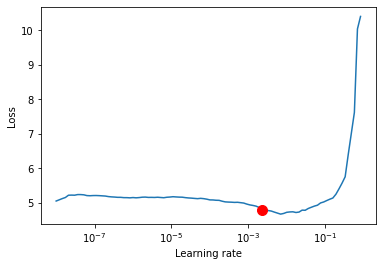

In [8]:
# early_stop_callback = EarlyStopping(
#    monitor='train_epoch_loss',
#    min_delta=0.00,
#    patience=20,
#    verbose=True,
#    mode='min'
# )

# callbacks=[early_stop_callback]



trainer = Trainer(auto_lr_find=0.0001, precision=16,gpus=-1, num_nodes=1,  max_epochs=1200, check_val_every_n_epoch=1,deterministic=True,gradient_clip_val=0.5,enable_pl_optimizer=True)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f"Suggested lr = {new_lr}")


### Update the learnng rate and fit the model 

In [9]:
model.hparams.lr = new_lr # can devide by 10

# Fit model
trainer.fit(model,dm)



   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 801 K 
2  | encoder             | Embedding              | 30.5 K
3  | decoder             | Linear                 | 30.6 K
4  | train_F1            | F1                     | 0     
5  | val_F1              | F1                     | 0     
6  | test_F1             | F1                     | 0     
7  | val_CM_normalized   | ConfusionMatrix        | 0     
8  | val_CM_raw          | ConfusionMatrix        | 0     
9  | test_CM             | ConfusionMatrix        | 0     
10 | val_MCR             | MyClassificationReport | 0     
11 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params


>== Average Valid Loss = 4.648472785949707, F1 = 0.00721


>== Average Valid Loss = 4.704946517944336, F1 = 0.15026
>Epoch =1, Avg Training loss = 3.5671603679656982, F1 = 0.21188


>== Average Valid Loss = 4.378422737121582, F1 = 0.18115
>Epoch =2, Avg Training loss = 3.0870108604431152, F1 = 0.2411


>== Average Valid Loss = 4.374574184417725, F1 = 0.13451
>Epoch =3, Avg Training loss = 2.9538538455963135, F1 = 0.24855


>== Average Valid Loss = 4.326526641845703, F1 = 0.1669
>Epoch =4, Avg Training loss = 2.916355848312378, F1 = 0.25321


In [ ]:
trainer.test(datamodule=dm) # testing

In [ ]:
# accelerator='dp'
# progress_bar_refresh_rate=0 # set to zero to disable it

In [ ]:
# torch.ones(5) * 1/10